In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
import tensorflow as tf
np.random.seed(58)
tf.random.set_seed(34)
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from pyleaves.datasets import leaves_dataset, fossil_dataset, pnas_dataset, base_dataset
import neptune

BATCH_SIZE = 16
NUM_EXAMPLES = 2000

##########################################################################
##########################################################################

def image_reshape(x):
    return [
        tf.image.resize(x, (7, 7)),
        tf.image.resize(x, (14, 14)),
        x
    ]


def load_img(image_path):#, img_size=(224,224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def resize(image, h=512, w=512):
    return tf.image.resize_with_pad(image, target_height=h, target_width=w)


def create_mnist_dataset(batch_size):
    (train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    train_images = train_images.reshape([-1, 28, 28, 1]).astype('float32')
    train_images = train_images/127.5  - 1
    dataset = tf.data.Dataset.from_tensor_slices(train_images)
    dataset = dataset.map(image_reshape)
    dataset = dataset.cache()
    dataset = dataset.shuffle(len(train_images))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(1)
    return dataset


def prep_dataset(dataset, batch_size=32, buffer_size=100, shuffle=False, target_size=(512,512)):
    dataset = dataset.map(lambda x,y: (resize(x, *target_size),y), num_parallel_calls=-1)
    dataset = dataset.cache()
    dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(1)
    return dataset


def create_Imagenette_dataset(batch_size, target_size=(512,512)):
    
    data, info = tfds.load('Imagenette', as_supervised=True, with_info=True)
    train_data = prep_dataset(data['train'], 
                              batch_size=batch_size, 
                              buffer_size=info.splits['train'].num_examples,
                              shuffle=True,
                              target_size=target_size)
    val_data = prep_dataset(data['validation'], 
                            batch_size=batch_size,
                            target_size=target_size)
    
    return train_data, val_data, info

    
def create_pnas_dataset(batch_size):
    data_files = pnas_dataset.PNASDataset()
    dataset = tf.data.Dataset.from_tensor_slices(data_files.data['path'])
    dataset = dataset.map(load_img, num_parallel_calls=-1)
    dataset = dataset.map(resize, num_parallel_calls=-1)
    dataset = dataset.cache()
    dataset = dataset.shuffle(10)#len(data_files.data))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(1)
    return dataset

##########################################################################
##########################################################################

# use matplotlib to plot a given tensor sample
def plot_sample(sample, num_res=1):
    num_samples = min(NUM_EXAMPLES, len(sample[0]))

    grid = gridspec.GridSpec(num_res, num_samples)
    grid.update(left=0, bottom=0, top=1, right=1, wspace=0.01, hspace=0.01)
    fig = plt.figure(figsize=[num_samples, num_res])
    for x in range(num_res):
        images = sample[x].numpy() #this converts the tensor to a numpy array
        images = np.squeeze(images)
        for y in range(num_samples):
            ax = fig.add_subplot(grid[x, y])
            ax.set_axis_off()
            ax.imshow((images[y] + 1.0)/2, cmap='gray')
    plt.show()
    
    
preprocess_input(tf.zeros([4, 224, 224, 3]))
def apply_preprocess(x, y, num_classes=10):
    return preprocess_input(x), tf.one_hot(y, depth=num_classes)
    

def build_head(base, num_classes=10):
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense1 = tf.keras.layers.Dense(2048,activation='relu',name='dense1')#, kernel_initializer=tf.initializers.GlorotNormal())
    dense2 = tf.keras.layers.Dense(512,activation='relu',name='dense2')#, kernel_initializer=tf.initializers.GlorotNormal())
    prediction_layer = tf.keras.layers.Dense(num_classes,activation='softmax')#, kernel_initializer=tf.initializers.GlorotNormal())
    model = tf.keras.Sequential([
        base,
        global_average_layer,dense1,dense2,
        prediction_layer
        ])
    return model

def log_data(logs):
    for k, v in logs.items():
        neptune.log_metric(k, v)

neptune_logger = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_data(logs))

In [ ]:
import arrow

neptune.init(project_qualified_name=args.neptune_project_name)
# neptune_tb.integrate_with_tensorflow()
experiment_dir = '/media/data/jacob/sandbox_logs'
experiment_name = args.experiment_name


experiment_start_time = arrow.utcnow().format('YYYY-MM-DD_HH-mm-ss')
log_dir =os.path.join(experiment_dir, experiment_name, 'log_dir',PARAMS['loss'], experiment_start_time)
ensure_dir_exists(log_dir)

In [4]:
target_size = (224,224)

PARAMS
with neptune.create_experiment(name=experiment_name, params=PARAMS, upload_source_files=[__file__]):

    train_dataset, validation_dataset, info = create_Imagenette_dataset(BATCH_SIZE, target_size=target_size)
    num_classes = info.features['label'].num_classes

    train_dataset = train_dataset.map(lambda x,y: apply_preprocess(x,y,num_classes),num_parallel_calls=-1)
    validation_dataset = validation_dataset.map(lambda x,y: apply_preprocess(x,y,num_classes),num_parallel_calls=-1)


    steps_per_epoch = info.splits['train'].num_examples//BATCH_SIZE
    validation_steps = info.splits['validation'].num_examples//BATCH_SIZE

    loss = 'categorical_crossentropy'
    METRICS = ['accuracy']

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

    base = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                                    include_top=False,
                                                    input_tensor=Input(shape=(*target_size,3)))

    model = build_head(base, num_classes=num_classes)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=METRICS)

    callbacks = [neptune_logger,
                 EarlyStopping(monitor='val_loss', patience=5, verbose=1)]

    
    model.summary(print_fn=lambda x: neptune.log_text('model_summary', x))
    
    history = model.fit(train_dataset,
                        epochs=150,
                        callbacks=callbacks,
                        validation_data=validation_dataset,
                        shuffle=True,
                        initial_epoch=0,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps)

In [3]:
K.clear_session()

big_target_size = (256,256)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

big_base = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                             include_top=False,
                                             input_tensor=Input(shape=(*big_target_size,3)))

big_model = build_head(big_base, num_classes=num_classes)

big_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=METRICS)

In [ ]:
callbacks = [neptune_logger,
             EarlyStopping(monitor='val_loss', patience=5, verbose=1)]

train_dataset, validation_dataset, info = create_Imagenette_dataset(BATCH_SIZE, target_size=big_target_size)
num_classes = info.features['label'].num_classes
BATCH_SIZE = 1

steps_per_epoch = info.splits['train'].num_examples//BATCH_SIZE
validation_steps = info.splits['validation'].num_examples//BATCH_SIZE
history = big_model.fit(train_dataset,
                    epochs=150,
                    callbacks=callbacks,
                    validation_data=validation_dataset,
                    shuffle=True,
                    initial_epoch=0,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Train for 9469 steps, validate for 3925 steps
Epoch 1/150
7276/9469 [======================>.......] - ETA: 5:49 - loss: 3594576333428383232.0000 - accuracy: 0.0000e+00

## Train Imagenette

(16, 224, 224, 3)


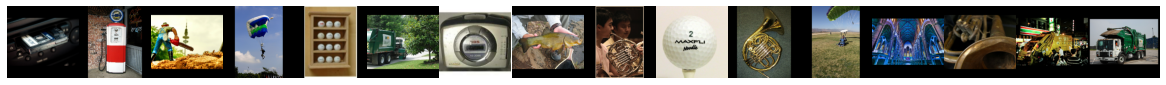

(16, 224, 224, 3)


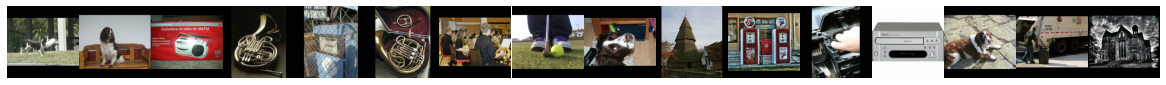

(16, 224, 224, 3)


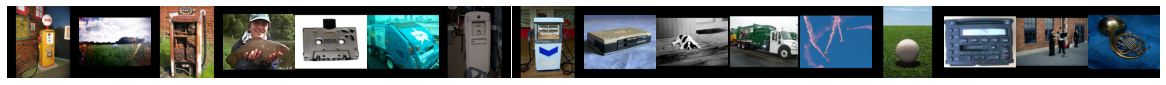

(16, 224, 224, 3)


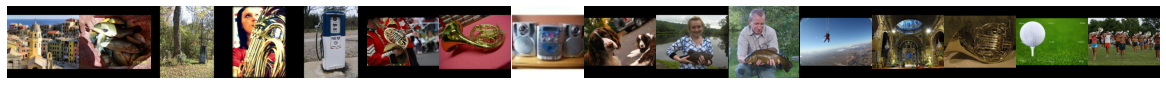

(16, 224, 224, 3)


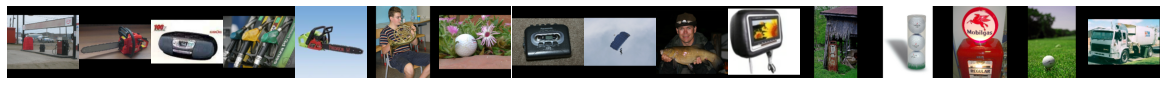

In [13]:
# train_dataset, validation_dataset = create_Imagenette_dataset(BATCH_SIZE)
for sample in train_dataset.take(5): # the dataset has to fit in memory with eager iteration
    print(sample[0].shape)
    plot_sample([sample[0]/127.5-1.0], num_res=1)

# print([s.shape for s in sample])

In [20]:
sample[0].numpy().min()
sample[0].numpy().max()

255.0

In [27]:
print(preprocess_input(sample[0]).numpy().min())
print(preprocess_input(sample[0]).numpy().max())

-123.68
151.061


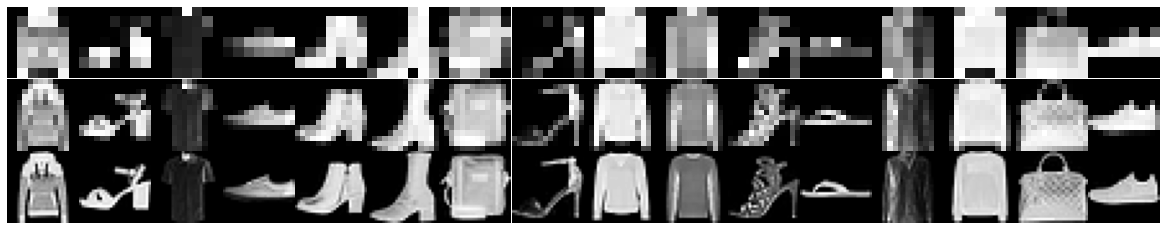

[TensorShape([16, 7, 7, 1]), TensorShape([16, 14, 14, 1]), TensorShape([16, 28, 28, 1])]


In [6]:
dataset =  create_mnist_dataset(BATCH_SIZE)
for sample in dataset.take(1): # the dataset has to fit in memory with eager iteration
    plot_sample(sample, num_res=3)

print([s.shape for s in sample])

In [6]:
big_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 768, 768, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 384, 384, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 384, 384, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 192, 192, 128)     0     

In [7]:
base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(big_base, to_file='model.png', show_shapes=True)

In [ ]:
    
# dataset =  create_pnas_dataset(BATCH_SIZE)
# dataset =  create_mnist_dataset(BATCH_SIZE)
# for sample in dataset: # the dataset has to fit in memory with eager iteration
#     plot_sample([sample], num_res=1)



In [18]:
num_params_big = 0
for layer in big_base.layers:
    num_params_big += np.prod(layer.output_shape[1:])
print(num_params_big)

177242113.0


In [19]:
num_params = 0
for layer in base.layers:
    num_params += np.prod(layer.output_shape[1:])
print(num_params)

print(num_params_big - num_params)

In [1]:
from pyleaves.mains import main_single_dataset_experiment

OpenCV is built with OpenMP support. This usually results in poor performance. For details, see https://github.com/tensorpack/benchmarks/blob/master/ImageNet/benchmark-opencv-resize.py



In [2]:
import sys
sys.argv.extend(['--gpu','6'])

main_single_dataset_experiment.main()

--gpu  6
os.environ["CUDA_VISIBLE_DEVICES"] :  6
tf.executing_eagerly() False

Set seeds [PYTHONHASHSEED, random, np.random, tf.set_random_seed] = 10293


/media/data/conda/jacob/envs/pyleaves/lib/python3.7/site-packages/tensorflow_core/contrib/learn/python/learn/learn_io/generator_io.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Container




EXECUTING EAGERLY:  False
/media/data/jacob/Fossil_Project/experiments/mlflow
INFO:tensorflow:Assets written to: /media/data_cifs/jacob/Fossil_Project/models/PNAS/vgg16_grayscale-saved_base_model/assets
Saved model vgg16_grayscale at path: /media/data_cifs/jacob/Fossil_Project/models/PNAS/vgg16_grayscale-saved_base_model
{'augment_images': True,
 'batch_size': 32,
 'data_config': {'class_weights_filepath': '/media/data_cifs/jacob/Fossil_Project/data/csv_data/A_train_val_test/PNAS/train_class_weights.csv',
                 'dataset_A': {'batch_size': 32,
                               'csv_data': {'test': '/media/data_cifs/jacob/Fossil_Project/data/csv_data/A_train_val_test/PNAS/test_data.csv',
                                            'train': '/media/data_cifs/jacob/Fossil_Project/data/csv_data/A_train_val_test/PNAS/train_data.csv',
                                            'val': '/media/data_cifs/jacob/Fossil_Project/data/csv_data/A_train_val_test/PNAS/val_data.csv'},
        

2020-05-06 00:48:38.889 | INFO     | pyleaves.loggers.mlflow_logger:log_history:58 - {
  "loss": [
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN,
    NaN
  ],
  "accuracy": [
    0.6797372698783875,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646,
    0.7671178579330444,
    0.7670514583587646,
    0.7670514583587646,
    0.7670514583587646
  ],
  "precision": [
    0.04405474662780762,
    0.0,
 

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [2]:
help(''.zfill)

Help on built-in function zfill:

zfill(width, /) method of builtins.str instance
    Pad a numeric string with zeros on the left, to fill a field of the given width.
    
    The string is never truncated.



In [1]:
# %debug

import os
gpu=6
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import pyleaves
from pyleaves import EXPERIMENTS_DB
from pyleaves.leavesdb.experiments_db import TFRecordsTable, get_db_table, get_db_contents
from pyleaves.configs.config_v2 import BaseConfig
from pyleaves.base.base_data_manager import DataManager
from pyleaves.base.base_trainer import ModelBuilder, BaseTrainer
from pyleaves.loggers.mlflow_logger import MLFlowLogger as Logger
from pyleaves.train.callbacks import get_callbacks
import sys
from stuf import stuf
from pprint import pprint


In [2]:
pyleaves.EXPERIMENTS_DB = '/home/jacob/projects/pyleaves/pyleaves/leavesdb/resources/experiments.db'

config = BaseConfig().parse(args=[], namespace=stuf({
                                                    'dataset_A':'Leaves',
                                                    'model':'vgg16',
                                                     'gpu':'5'}))
#                                                     'run_id':'1000'}))

config

data_manager = DataManager(config=config)
train_data = data_manager.get_data_loader(file_group='train')
val_data = data_manager.get_data_loader(file_group='val')
test_data = data_manager.get_data_loader(file_group='test')

model_builder = ModelBuilder(config)
model = model_builder.build_model()
#model_factory is dynamically defined based on the type of model used, brings with it useful model save/load methods.
model_factory = model_builder.model_factory

INFO:tensorflow:Assets written to: /media/data_cifs/jacob/Fossil_Project/models/Leaves/vgg16_grayscale-saved_base_model/assets
Saved model vgg16_grayscale at path: /media/data_cifs/jacob/Fossil_Project/models/Leaves/vgg16_grayscale-saved_base_model


In [ ]:
callbacks = get_callbacks(weights_best=os.path.join(config.model_config.model_dir,'weights_best.h5'),
                              logs_dir=os.path.join(config.model_config.log_dir,'tensorboard_logs'),
                              val_data=None,#val_data,
                              batches_per_epoch=0,#30,
                              freq=5,
                              histogram_freq=0,
                              restore_best_weights=True,
                              seed=config.seed)

logger = Logger(config)

trainer = BaseTrainer(config, model_builder, data_manager, logger, callbacks)
trainer.train()

/media/data/jacob/Fossil_Project/experiments/mlflow
INFO:tensorflow:Assets written to: /media/data_cifs/jacob/Fossil_Project/models/Leaves/vgg16_grayscale-saved_base_model/assets
Saved model vgg16_grayscale at path: /media/data_cifs/jacob/Fossil_Project/models/Leaves/vgg16_grayscale-saved_base_model
Train for 471 steps, validate for 117 steps
Epoch 1/100
471/471 [==============================] - 151s 320ms/step - loss: 11.7102 - accuracy: 0.0336 - precision: 0.0484 - recall: 8.3916e-04 - top_3_categorical_accuracy: 0.0825 - top_5_categorical_accuracy: 0.1161 - val_loss: 21.6709 - val_accuracy: 0.0182 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_3_categorical_accuracy: 0.0649 - val_top_5_categorical_accuracy: 0.0857
Epoch 2/100
471/471 [==============================] - 132s 280ms/step - loss: 59.9061 - accuracy: 0.0330 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_3_categorical_accuracy: 0.0822 - top_5_categorical_accuracy: 0.1221 - val_loss: 132.4716 - val_accu

In [ ]:
#This is for scratch work developing the main training pipeline

# import json
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# from stuf import stuf

# import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
# import pyleaves
# # from pyleaves import leavesdb
# from pyleaves.base.base_data_manager import DataManager
# from pyleaves.base.base_trainer import ModelBuilder, BaseTrainer
# from pyleaves.configs.config_v2 import BaseConfig
# from pyleaves.leavesdb import experiments_db
# from pyleaves.leavesdb.experiments_db import DataBase, Table, TFRecordsTable, EXPERIMENTS_SCHEMA, TFRecordItem, EXPERIMENTS_DB
# from pyleaves.leavesdb.experiments_db import get_db_table, select_by_col, select_by_multicol
# from pyleaves.leavesdb.tf_utils.create_tfrecords import save_tfrecords
# from pyleaves.datasets import leaves_dataset, fossil_dataset, pnas_dataset, base_dataset
# from pyleaves.utils.create_experiments import create_experiment__A_train_val_test
# import time


# experiments_db.create_db()

# tables = experiments_db.get_db_contents()

# create_experiment__A_train_val_test()

# get_db_table(tablename='tfrecords')

########################################################################
########################################################################

# config = BaseConfig().parse(args=['--grayscale'], namespace=stuf({'run_id':'1000'}))

# data_manager = DataManager(config=config)
# train_data = data_manager.get_data_loader(file_group='train')
# val_data = data_manager.get_data_loader(file_group='val')
# test_data = data_manager.get_data_loader(file_group='test')

# from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# self = data_manager
# tfrecord_paths = self.get_tfrecord_paths_by_file_group(file_group='train')
# # tfrecord_paths = self.get_tfrecord_paths_by_file_group(file_group='val')
# # tfrecord_paths = self.get_tfrecord_paths_by_file_group(file_group='test')
# tfrecord_paths

# config = self.config
# self.num_classes = self.get_num_classes()
# self.target_size = config.model_config.input_shape[:-1]
# self.num_channels = config.model_config.input_shape[-1]

# preprocess_input = lambda x,y: (resnet_preprocess_input(x),y)
# data = tf.data.Dataset.from_tensor_slices(tfrecord_paths) \
#             .apply(lambda x: tf.data.TFRecordDataset(x)) \
#             .map(self.decode_example, num_parallel_calls=AUTOTUNE) \
#             .map(preprocess_input, num_parallel_calls=AUTOTUNE)

# imgs, labels = next(iter(data))
# print(np.min(imgs.numpy()),np.max(imgs.numpy()))

# plt.imshow(imgs.numpy()/2.0 + 0.5)

# if config.grayscale == True:
#     if self.num_channels==3:
#         data = data.map(rgb2gray_3channel, num_parallel_calls=AUTOTUNE)
#     elif self.num_channels==1:
#         data = data.map(rgb2gray_1channel, num_parallel_calls=AUTOTUNE)

# if file_group == 'train':
#     if config.augment_images:
#         data = data.map(self.augmentors.rotate, num_parallel_calls=AUTOTUNE) \
#                    .map(self.augmentors.flip, num_parallel_calls=AUTOTUNE)

#     data = data.shuffle(buffer_size=1000, seed=config.seed)

# data = data.batch(config.batch_size, drop_remainder=False) \
#            .repeat() \
#            .prefetch(AUTOTUNE)

In [4]:
# config = BaseConfig().parse(args=['--grayscale'], namespace=stuf({'run_id':'1000'}))

# data_manager = DataManager(config=config)
# train_data = data_manager.get_data_loader(file_group='train')
# val_data = data_manager.get_data_loader(file_group='val')
# test_data = data_manager.get_data_loader(file_group='test')

# # create an instance of the model you want
# model_builder = ModelBuilder(config)
# model = model_builder.build_model()
# #model_factory is dynamically defined based on the type of model used, brings with it useful model save/load methods.
# model_factory = model_builder.model_factory

# trainer = BaseTrainer(config, model, data_manager)

# config=BaseConfig().parse(args=['--grayscale'], namespace=stuf({'run_id':'1000'}))
# print(json.dumps(config, indent='\t'))

# data_manager = DataManager(config=config)

# train_data = data_manager.get_data_loader(file_group='train')
# batch_data = next(iter(train_data))
# batch_data[1].shape

##############################
# hashes = []

# for f in train_record_paths:
#     binary_file = open(f, 'rb').read()
#     hashes.append(str(hash(binary_file)))

# print(len(hashes), len(set(hashes)))
# print('\n'.join(hashes))

# hashes_old = list(hashes)

# for old, new in zip(hashes_old, hashes):
#     print(old, new, old==new)
#########################

# datasets = {
#         'PNAS': pnas_dataset.PNASDataset(),
#         'Leaves': leaves_dataset.LeavesDataset(),
#         'Fossil': fossil_dataset.FossilDataset()
#         }

# experiment_view = select_by_col(table=tables['runs'],column='experiment_type',value='A_train_val_test')
# for i, run in experiment_view.iterrows():
#     run_config = stuf(run.to_dict())

#     # RunItem = partial(TFRecordItem, **{col:run_config[col] for col in ['run_id', 'experiment_type']})
#     print('BEGINNING ', run)
#     config = BaseConfig().parse(namespace=run_config)
#     tfrecords_table = TFRecordsTable(db_path=config.user_config.experiments_db)
#     # num_classes = config.data_config.dataset_A.num_classes
#     num_shards = config.data_config.dataset_A.num_shards
#     resolution = config.data_config.dataset_A.resolution

#     name = config.dataset_A
#     data = datasets[name]
#     encoder = base_dataset.LabelEncoder(data.data.family)
#     num_classes = config.data_config.dataset_A.num_classes = encoder.num_classes
#     processed = base_dataset.preprocess_data(data, encoder, config.data_config.dataset_A)
    
#     break
    

# import json
# print(json.dumps(config,indent='\t'))
# print(json.dumps(config.data_config.dataset_A.csv_data,indent='\t'))

# create_experiment__A_train_val_test()

